In [1]:
import os
import requests
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [3]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=360,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

valid_datagen = ImageDataGenerator(    
    rescale=1./255,
    rotation_range=360,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=360,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

training_dir = r'D:\DATASET\color_model\elevation\train_dataset'
validation_dir = r'D:\DATASET\color_model\elevation\val_dataset'
testing_dir = r'D:\DATASET\color_model\elevation\test_dataset'

In [4]:
# Load the training dataset using the ImageDataGenerator
train_dataset = train_datagen.flow_from_directory(
    training_dir,
    target_size=(24, 24),
    batch_size=30,
    class_mode='categorical',
    shuffle=False
)


# Load the validation dataset using the ImageDataGenerator
validation_dataset = valid_datagen.flow_from_directory(
    validation_dir,
    target_size=(24, 24),  
    batch_size=30,
    class_mode='categorical',
    shuffle=False
)

# Load the validation dataset using the ImageDataGenerator
testing_dataset = valid_datagen.flow_from_directory(
    testing_dir,
    target_size=(24, 24),  
    batch_size=30,
    class_mode='categorical',
    shuffle=False
)

Found 15120 images belonging to 16 classes.
Found 2160 images belonging to 16 classes.
Found 4320 images belonging to 16 classes.


In [5]:
# Print the number of classes in the dataset
num_classes = len(train_dataset.class_indices)
print("Number of classes:", num_classes)


Number of classes: 16


In [6]:
# Print the names of the classes
class_names = list(train_dataset.class_indices.keys())
print("Class names:", class_names)


Class names: ['+15', '+25', '+35', '+45', '+5', '+55', '+65', '+75', '-15', '-25', '-35', '-45', '-5', '-55', '-65', '-75']


In [7]:
# Print the number of training and validation images
print("Number of training images:", train_dataset.n)
print("Number of validation images:", validation_dataset.n)


Number of training images: 15120
Number of validation images: 2160


In [8]:

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(24, 24, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(16, activation='softmax')
])


In [9]:
# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.0035)  
model.compile(
    optimizer=opt,
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [10]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 22, 22, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 128)        0

In [11]:
# Define the checkpoint callback to save the model with the minimum loss
checkpoint_callback = ModelCheckpoint('elevation_color_model.h5', 
                                      monitor='val_loss', 
                                      mode="min",
                                      save_best_only=True)

In [12]:
# Define early stopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  
    patience=5,          
    verbose=1,            
    restore_best_weights=True  
)

In [13]:
# Train the model with the checkpoint callback
history = model.fit(train_dataset,
                    batch_size=30,
                    epochs=100, 
                    validation_data=validation_dataset, 
                    callbacks=[checkpoint_callback,early_stopping_callback])

Epoch 1/100
504/504 [==============================] - 20s 36ms/step - loss: 1.8856 - accuracy: 0.3255 - val_loss: 1.2351 - val_accuracy: 0.4375
Epoch 2/100
504/504 [==============================] - 18s 35ms/step - loss: 1.0741 - accuracy: 0.5596 - val_loss: 0.7666 - val_accuracy: 0.6250
Epoch 3/100
504/504 [==============================] - 20s 39ms/step - loss: 0.8840 - accuracy: 0.6617 - val_loss: 0.5105 - val_accuracy: 0.7500
Epoch 4/100
504/504 [==============================] - 23s 45ms/step - loss: 0.9500 - accuracy: 0.6167 - val_loss: 0.3676 - val_accuracy: 0.8750
Epoch 5/100
504/504 [==============================] - 27s 53ms/step - loss: 0.8231 - accuracy: 0.6571 - val_loss: 0.5690 - val_accuracy: 0.8125
Epoch 6/100
504/504 [==============================] - 27s 53ms/step - loss: 0.6786 - accuracy: 0.7460 - val_loss: 0.5930 - val_accuracy: 0.6875
Epoch 7/100
504/504 [==============================] - 27s 53ms/step - loss: 1.0733 - accuracy: 0.6547 - val_loss: 0.7026 - val_ac

In [14]:
# Evaluate the model on the train dataset

model = tf.keras.models.load_model(r'elevation_color_model.h5')
loss, accuracy = model.evaluate(train_dataset)
print('Train Accuracy: {:.2f}%'.format(accuracy*100))
print('Train Loss: {:.2f}'.format(loss))


504/504 [==============================] - 13s 26ms/step - loss: 0.3676 - accuracy: 0.8750
Train Accuracy: 87.50%
Train Loss: 0.37


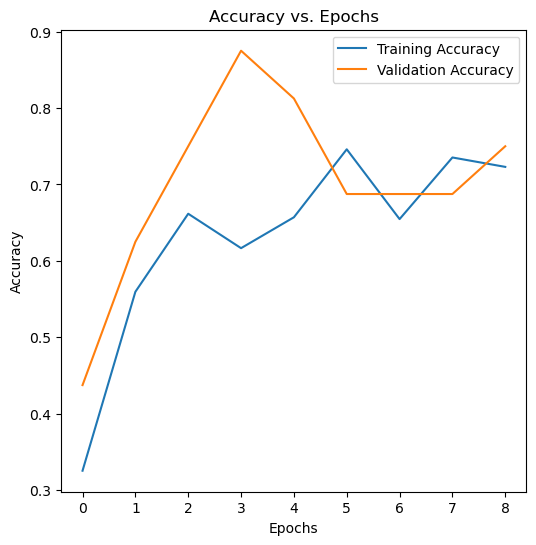

In [15]:
# Plot accuracy vs. epochs
plt.figure(figsize=(6, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.savefig('accuracy_vs_epochs.png') 

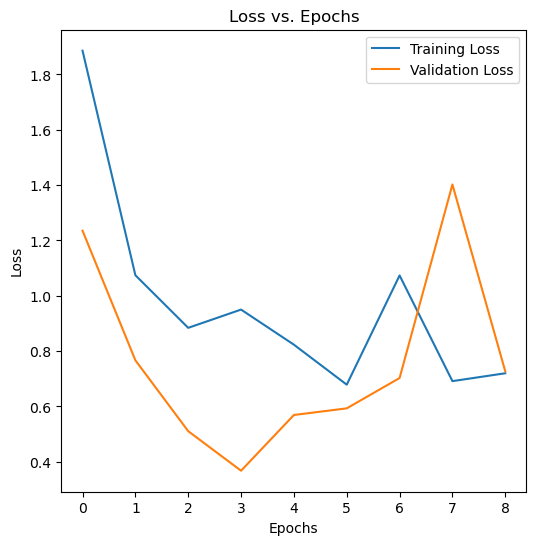

In [16]:
# Plot loss vs. epochs
plt.figure(figsize=(6, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.savefig('loss_vs_epochs.png')  
plt.show()

In [17]:
# Load the saved model
model = tf.keras.models.load_model(r'elevation_color_model.h5')

# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(testing_dataset)
print('Test Accuracy: {:.2f}%'.format(accuracy*100))
print('Test Loss: {:.2f}'.format(loss))


144/144 [==============================] - 11s 77ms/step - loss: 0.3676 - accuracy: 0.8750
Test Accuracy: 87.50%
Test Loss: 0.37
